# <center><span style="color:blue; font-size: 2em"> Stocks, Significance Testing & p-Hacking: How <span style="color:green"> volatile </span> <span style="color:red"> is volatile? </span></span></center>


>## ** October is historically the most volatile month for stocks, but is this a persistent signal or just noise in the data?**


![](https://cdn-images-1.medium.com/max/600/1*D0_bUZNtw_3aq_CyMqj0dw.gif)


### Stocks, Significance Testing & p-Hacking.

 <center><span style=" font-size: 20px"> Over the past 32 years, October has been the most volatile month on average for the S&P500 and December the least, in this article we will use simulation to assess the statistical significance of this observation and to what extent this observation could occur by chance.</span> </center>

### Our goal:

*  [**Demonstrate how to use Pandas to analyze Time Series**](#Wrangle-with-Pandas:)
* [**Understand how to construct a hypothesis test**](#Hypothesis-Testing:-What’s-the-question?)
* [**Use simulation to perform hypothesis testing**](#Simulation)
* [**Show the importance of accounting for multiple comparison bias**](#p-Hacking)

### Our data:

We will be using Daily S&P500 data for this analysis, in particular we will use the raw daily closing prices from 1986 to 2018 (which is surprisingly hard to find so I’ve made it [publicly available](https://www.kaggle.com/pdquant/sp500-daily-19862018)).

The inspiration for this post came from [Winton](https://www.winton.com/research/seasonal-volatility-and-the-multiplicity-effect), which we will be reproducing here, albeit with 32 years of data vs their 87 years.



### Wrangle with Pandas:

To answer the question of whether the extreme volatility seen in certain months really is significant, we need to transform our 32yrs of price data into a format that shows the phenomena we are investigating.

Our format of choice will be **average monthly volatility rankings (AMVR)**.

The following code shows how we get our raw price data into this format:

In [1]:
#standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import pandas_datareader.data as web
import seaborn as sns

A nice trick to make charts display full width in Jupyter notebooks:

In [2]:
#resize charts to fit screen if using Jupyter Notebook
plt.rcParams['figure.figsize']=[20,5]

import our data and convert into daily returns using pct_change

In [3]:
#Daily S&P500 data from 1986==>
url = "../input/spx.csv"
df = pd.read_csv(url,index_col='date', parse_dates=True)

#view raw S&P500 data
df.head()

,close
date,
1986-01-02,209.59
1986-01-03,210.88
1986-01-06,210.65
1986-01-07,213.80
1986-01-08,207.97


Now we use one of the more powerful tools in Pandas: [Resample](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwiJl6ShnJXeAhXHK8AKHQBCCAsQFjAAegQIBxAB&url=https%3A%2F%2Fpandas.pydata.org%2Fpandas-docs%2Fstable%2Fgenerated%2Fpandas.DataFrame.resample.html&usg=AOvVaw1le9agxvLanaQp9zlNYG9Y). This allows us to change the frequency of our data from daily to monthly and to use standard deviation as a measure of volatility. These are the design choices we have when constructing an analysis.

In [ ]:
#To model returns we will use daily % change
daily_ret = df['close'].pct_change()
#drop the 1st value - nan
daily_ret.dropna(inplace=True)
#daily %change
daily_ret.head()

date
1986-01-03    0.006155
1986-01-06   -0.001091
1986-01-07    0.014954
1986-01-08   -0.027268
1986-01-09   -0.008944
Name: close, dtype: float64

A quick look at the annualized monthly vol, shows major market events clearly, such as Black Monday and the 2008 Financial Crisis.

date
1986-01-31    0.033317
1986-02-28    0.023585
1986-03-31    0.027961
1986-04-30    0.037426
1986-05-31    0.027412
Freq: M, Name: close, dtype: float64


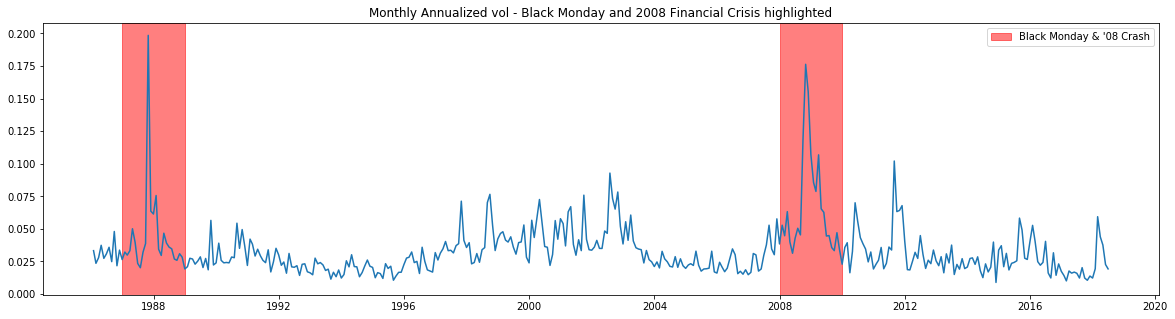

In [ ]:
#use pandas to resample returns per month and take Standard Dev as measure of Volatility
#then annualize by multiplying by sqrt of number of periods (12)
mnthly_annu = daily_ret.resample('M').std()* np.sqrt(12)

print(mnthly_annu.head())
#we can see major market events show up in the volatility
plt.plot(mnthly_annu)
plt.axvspan('1987','1989',color='r',alpha=.5)
plt.axvspan('2008','2010',color='r',alpha=.5)
plt.title('Monthly Annualized vol - Black Monday and 2008 Financial Crisis highlighted')
labs = mpatches.Patch(color='red',alpha=.5, label="Black Monday & '08 Crash")
plt.legend(handles=[labs])


Here’s where we can use the power of pandas to group our volatility by year and create a ranking for each of the 12 months over all 32 years of data

In [ ]:
#for each year rank each month based on volatility lowest=1 Highest=12
ranked = mnthly_annu.groupby(mnthly_annu.index.year).rank()

#average the ranks over all years for each month
final = ranked.groupby(ranked.index.month).mean()

final.describe()

count    12.000000
mean      6.450521
std       0.627458
min       5.218750
25%       6.031013
50%       6.491004
75%       6.704545
max       7.531250
Name: close, dtype: float64

this gives our final** Average Monthly Volatility Rankings**. Numerically we can see that **month 10 (October) is the highest and 12 (December) is the lowest**.

In [ ]:
#the final average results over 32 years 
final

date
1     6.818182
2     6.666667
3     6.575758
4     7.303030
5     6.606061
6     6.030303
7     6.031250
8     5.875000
9     6.406250
10    7.531250
11    6.343750
12    5.218750
Name: close, dtype: float64

By plotting our AMVR we can clearly see the most volatile month has been October and the lowest, December.

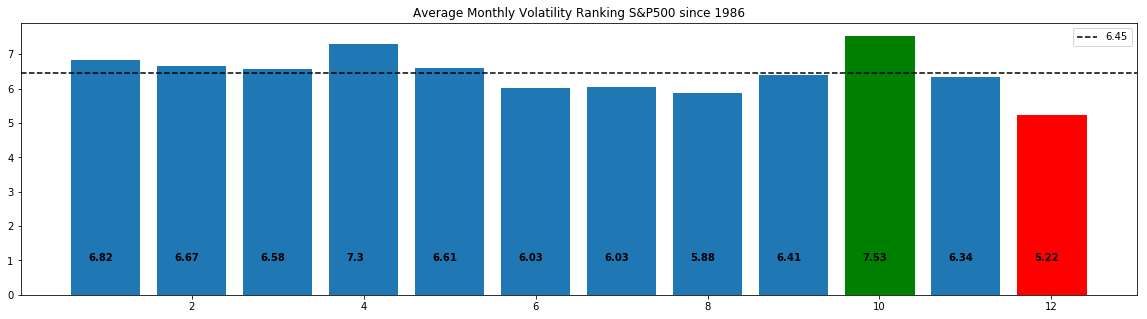

In [ ]:
#plot results for ranked s&p 500 volatility
#clearly October has the highest AMVR
#and December has the lowest
#mean of 6.45 is plotted

b_plot = plt.bar(x=final.index,height=final)
b_plot[9].set_color('g')
b_plot[11].set_color('r')
for i,v in enumerate(round(final,2)):
    plt.text(i+.8,1,str(v), color='black', fontweight='bold')
plt.axhline(final.mean(),ls='--',color='k',label=round(final.mean(),2))
plt.title('Average Monthly Volatility Ranking S&P500 since 1986')

plt.legend()
plt.show()




So that’s our data, now onto Hypothesis testing…

### Hypothesis Testing: What’s the question?

Hypothesis testing is one of the most fundamental techniques of data science, yet it is one on the most intimidating and misunderstood. The basis for this fear, is the way it is taught in Stats 101, where we are told to:

*"perform a t-test, is it a one-sided or two-sided test?, choose a suitable test-statistic such as Welch’s t-test, calculate degrees of freedom, calculate the t score, look up the critical value in a table, compare critical value to t statistic ……"*

![](https://cdn-images-1.medium.com/max/800/1*_yxe_kGGtT9m4qd6ahGohQ.png)

Understandably, this is leads to confusion over what test to conduct and how to conduct it. However, all of these classical statistical techniques for performing a hypothesis test, were developed at a time when we had very little computing power and were simply closed-form analytical solutions for calculating a p-value,that's it! But with the added complication of needing to pick the right formula for the given situation, due to their restrictive and sometimes opaque assumptions.

But rejoice!

There is a better way. Simulation.

To understand how simulation can help us, lets remind ourselves what a hypothesis test is:

We wish to test ***“whether the observed effect in our data is real or whether it could happen simply by chance”***
and to perform this test we do the following:
   *  Choose an appropriate ‘test statistic’: this is simply a number that measures the observed effect. In our case we will choose the **absolute deviation in AMVR from the mean**.
   * Construct a Null Hypothesis: this is simply a version of the data where the observed effect in not present. In our case we will shuffle the labels of the data repeatedly **permutation**. The justification for this is detailed below.
   * Compute a p-value: this is the probability of seeing the observed effect amongst the null data, in other words, by chance. **We do this through repeated simulation** of the null data. In our case, we shuffle the ‘date’ labels of the data many times and simply count the occurrence of our test statistic as it appears through multiple simulations.
   
>    That’s hypothesis testing in 3 steps! No matter what phenomena we are testing, the question is always the same: “**is the observed effect real, or is it due to chance**”

[There is only one test! This great blog by Allen Downey has more details on hypothesis testing](http://allendowney.blogspot.com/2011/05/there-is-only-one-test.html)

**The real power of simulation is that we have to make explicit what our model assumptions are through code**. Whereas classical techniques can be a ‘black-box’ when it comes to there assumptions.

Example below: The left plot shows the true data and the observed effect with a certain probability (green). The right plot is our simulated null data with a recording of when the observed effect was seen by chance (red). This is the basis of hypothesis testing, what is the probability of seeing the observed effect in our null data.

![](https://cdn-images-1.medium.com/max/1000/1*UW9OJHyVcl0qWWikSv0kpQ.png)

The most important part of hypothesis testing is being clear what question we are trying to answer. In our case we are asking:

“**Could the most extreme value happen by chance?**”

The most extreme value we define as the **greatest absolute AMVR deviation from the mean**. This question forms our null hypothesis.

In our data the most extreme value is the December value (1.23) not the October value (1.08), because we are looking at the biggest absolute deviation from the mean not simply the highest volatility:

In [ ]:
#take abs value move from the mean
#we see Dec and Oct are the biggest abs moves

fin = abs(final - final.mean())
print(fin.sort_values())
Oct_value = fin[10]
Dec_value = fin[12]
print('Extreme Dec value:', Dec_value)
print('Extreme Oct value:', Oct_value)


date
9     0.044271
11    0.106771
3     0.125237
5     0.155540
2     0.216146
1     0.367661
7     0.419271
6     0.420218
8     0.575521
4     0.852509
10    1.080729
12    1.231771
Name: close, dtype: float64
Extreme Dec value: 1.231770833333333
Extreme Oct value: 1.080729166666667


### Simulation

Now we know what question we are asking, we need to construct our ‘Null Model’.

There are a number of options here:

   * **Parametric models**. If we had a good idea of the data distribution or simply made assumption on it, we could use ‘classical’ hypothesis testing techniques, t-test, X², one-way ANOVA etc. These models can be restrictive and something of a blackbox if their assumptions aren’t fully understood by the researcher.
   * **Direct Simulation**. We could make assumptions about the [data generating process](http://www.rimini.unibo.it/fanelli/econometric_models2_2012.pdf) and simulate directly. For example we could specify an ARMA time series model for the financial data we are modeling and deliberately engineer it to have no seasonality. This could be a reasonable choice for our problem, however if we knew the data generating process for the S&P500 we would be rich already!
   * **Simulation through Resampling**. This is the approach we will take. By repeatedly sampling at random from the existing dataset and shuffling the labels, we can make the observed effect equally likely amongst all labels in our data (in our case the labels are the dates), thus giving the desired null dataset.

Sampling is a big topic but we will focus on one particular technique, **[permutation](https://speakerdeck.com/jakevdp/statistics-for-hackers)** or shuffling.

To get the desired null model, we need to construct a dataset that has **no seasonality** present. If the null is true, *that there is no seasonality in the data and the observed effect was simply by chance*, then the labels for each month (Jan,Feb etc) are meaningless and therefore we can shuffle the data repeatedly to build up what classical statistics would call the ‘*[sampling distribution of the test statistic under the null hypothesis](https://www.youtube.com/watch?time_continue=441&v=5Dnw46eC-0o)*’. This has the desired effect of making the observed phenomena (the extreme December value) **equally likely** for all months, which is exactly what our null model requires.

To prove how powerful simulation techniques are with modern computing power, the code in this example will actually permute the daily price data, which requires lots more processing power, yet still completes in seconds on a modern CPU. 

Note: *shuffling either the daily or the monthly labels will give us the desired null dataset in our case.*

                              Shuffle 'date' label to create null dataset
![](https://cdn-images-1.medium.com/max/1000/1*-rzHR7JrlTjcXAYp4zKCUA.gif)

A great resource for learning about sampling is by [Julian Simon](http://www.resample.com/intro-text-online/).

Note: *The way our test is constructed is the equivalent of a two sided test using ‘classical’ methods, such as Welch’s t-test or ANOVA etc, because we are interested in the most extreme value, either above or below the mean.*

These decisions are design choices and we have this freedom because **the Null Model is just that, it’s a Model!** This means we can specify its parameters as we choose, the key is to really be clear what question we are trying to answer.

Below is the code to simulate 1000 sets of 12 AMVR, permuting the date labels each time to build up the sampling distribution. The output from this code is included below in the p-hacking section…

In [ ]:
#as our Null is that no seasonality exists or alternatively that the month does not matter in terms of AMVR,
#we can shuffle 'date' labels
#for simplicity, we will shuffle the 'daily' return data, which has the same effect as shuffling 'month' labels

#generate null data 

new_df_sim = pd.DataFrame()
highest_only = []

count=0
n=1000
for i in range(n):
    #sample same size as dataset, drop timestamp
    daily_ret_shuffle = daily_ret.sample(8191).reset_index(drop=True)
    #add new timestamp to shuffled data
    daily_ret_shuffle.index = (pd.bdate_range(start='1986-1-3',periods=8191))
    
    #then follow same data wrangling as before...
    mnthly_annu = daily_ret_shuffle.resample('M').std()* np.sqrt(12)
    
    ranked = mnthly_annu.groupby(mnthly_annu.index.year).rank()
    sim_final = ranked.groupby(ranked.index.month).mean()
    #add each of 1000 sims into df
    new_df_sim = pd.concat([new_df_sim,sim_final],axis=1)
    
    #also record just highest AMVR for each year (we will use this later for p-hacking explanation)
    maxi_month = max(sim_final)
    highest_only.append(maxi_month)
    

    
#calculate absolute deviation in AMVR from the mean
all_months = new_df_sim.values.flatten()
mu_all_months = all_months.mean()
abs_all_months = abs(all_months-mu_all_months)    

#calculate absolute deviation in highest only AMVR from the mean
mu_highest = np.mean(highest_only)
abs_highest = [abs(x - mu_all_months) for x in highest_only]



### p-Hacking

Here’s the interesting bit. We’ve constructed a hypothesis to test, we’ve generated simulated data by shuffling the ‘date’ labels of the data , now we need to perform our hypothesis test to find the probability of observing a result as significant as the December result given that the null hypothesis (no seasonality) is true.

Before we perform the test lets set our expectations.

**Whats the probability of seeing *at least one* significant result given a 5% significance level?**

= 1-p(not significant)

= 1-(1–0.05)¹²

= 0.46

so there’s a **46%** chance of seeing **at least one** month with a significant result, given our null is true.

Now lets ask, **for each individual test** (*comparing each of the 12 months absolute AMVR to the mean*) **how many significant values should we expect to see amongst our random, non-seasonal data?**

12 x 0.05 = 0.6

So with a 0.05 significance level we should expect a false positive rate of **0.6**. In other words, for each test (with the null data) comparing all 12 months AMVR to the mean, 0.6 months will have show a significant result.(*obviously we cant have less than 1 month showing a result, but under repeat testing the math should tend towards this number*).

All the way through this work, we have stressed the importance of being really clear with the question we are trying to answer. The problem with the expectations we’ve just calculated is **we have assumed we are testing for a significant result against all 12 months!** That’s why the probability of seeing at least one false positive is so high at 46%.

This is an example of [multiple comparison bias](https://www.quantopian.com/lectures/p-hacking-and-multiple-comparisons-bias). Where we have expanded our search space and increased the likelihood of finding a significant result. This a problem because we could abuse this phenomena to cherry pick the parameters of our model which give us the ‘desired’ p-value.

> This is the essence of p-Hacking

This xkcd nicely highlights the issue with multiple comparison bias and it’s subsequent abuse, p-hacking.


                               Whoa! Green Jelly beans are significant
![](https://cdn-images-1.medium.com/max/800/0*zZgRnBSbwUN3b6D5.png)

To illustrate the effect of p-hacking and how to reduce multiplicity, we need to understand the subtle but significant difference between the following 2 question:

*     **“Whats the probability that December would appear this extreme by chance.”**
*     **“Whats the probability any month would appear this extreme by chance."**

The beauty of simulation lies in its simplicity. The following code is all we need to compute the p-value to answer the 1st question. We simply count how many values in our dataset using all 12000 AMVR deviations (12 months x 1000 trials) are greater than the observed December value. We get a **p-value of 4.4%**, close to our somewhat arbitrary 5% cut off, but **significant** none the less.



In [ ]:
#count number of months in sim data where ave-vol-rank is >= Dec
#Note: we are using Dec not Oct, as Dec has highest absolute deviation from the mean
count=0
for i in abs_all_months:
    if i> Dec_value:
        count+=1
ans = count/len(abs_all_months)        
print('p-value:', ans )

To answer the 2nd question and to avoid multiplicity, instead of comparing our result to the distribution made with all 12000 AMVR deviations, we only consider the highest value from each of the absolute AMVR 1000 trials. This gives a **p-value of 23%**, very much **not significant!**

In [ ]:
#same again but just considering highest AMVR for each of 100 trials
count=0
for i in abs_highest:
    if i> Dec_value:
        count+=1
ans = count/len(abs_highest)        
print('p-value:', ans )

Now lets plot these distributions:

In [ ]:
abs_all_months_95 = np.quantile(abs_all_months,.95)
abs_highest_95 = np.quantile(abs_highest,.95)

fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,sharex='col',figsize=(20,20))

#need to normalize!

#plot 1
ax1.hist(abs_all_months,histtype='bar',color='#42a5f5')
ax1.set_title('AMVR all months',fontsize=30)
ax1.set_ylabel('Frequency',fontsize=20)
n,bins,patches = ax3.hist(abs_all_months,density=1,histtype='bar',cumulative=True,bins=30,color='#42a5f5')
ax3.set_ylabel('Cumulative probability',fontsize=20)
ax1.axvline(Dec_value,color='b',label='Dec Result',lw=10)
ax3.axvline(Dec_value,color='b',lw=10)
ax3.axvline(abs_all_months_95,color='r',ls='--',label='5% Sig level',lw=10)


#plot2
ax2.hist(abs_highest,histtype='bar',color='g')
ax2.set_title('AMVR highest only',fontsize=30)
ax2.axvline(Dec_value,color='b',lw=10)
n,bins,patches = ax4.hist(abs_highest,density=1,histtype='bar',cumulative=True,bins=30,color='g')
ax4.axvline(Dec_value,color='b',lw=10)
ax4.axvline(abs_highest_95,color='r',ls='--',lw=10)

ax1.legend(fontsize=15)
ax3.legend(fontsize=15)


The left column is the data that answers question 1 and the right column, question 2. The top row are the probability distributions and the bottom row are the CDF. The red dashed line is the 5% significance level that we arbitrarily decided upon. The blue line is the original extreme December AMVR value of 1.23.

The left side plot shows that the original December value is significant at a 5% level, but only just! However, when we account for multiple comparison bias, in the right hand plot the threshold for significance moves up from around 1.2 (abs AMVR) up to around 1.6 (see the redline).

>    **By accounting for multiple comparison bias our December value of 1.23 is no longer significant!**

By taking into consideration the specific question we are trying to answer and avoiding multiple comparison bias, we have avoided p-hacking our model and avoided showing a significant result when there isn’t one.

To further explore p-hacking and how it can be abused to tell a particular story about our data, see this great interactive app from [FiveThirtyEight](https://fivethirtyeight.com/features/science-isnt-broken/#part2)

### Conclusions

* **We have learnt that hypothesis testing is not the big scary beast we thought it was. Simply follow the 3 steps above to construct your model for any kind of data or test statistic.**

* **We’ve show that asking the right question is vital for scientific analysis. A slight change in the wording can lead to a very different model with very different results.**

* **We discussed the importance of recognizing and correcting for multiple comparison bias and avoiding the pitfalls of p-hacking and showed how a seemingly significant result can become non-significant.**

* **With more and more ‘big data’ along with academic pressure to produce a research paper with ‘novel’ findings or political pressure to show a result as being ‘significant’, the temptation for p-hacking is ever increasing. By learning to recongise when we are guilty of it and correcting for it accordingly we can become better researchers and ultimately produce more accurate and therefore actionable scientific results!**

Authors Notes: *Our results differ slightly from the original [Winton research](https://www.winton.com/research/seasonal-volatility-and-the-multiplicity-effect), this due in part to having a slightly different data set (32yrs vs 87yrs) and they have October being the month of interest whereas we have December. Also they used an undisclosed method for their ‘simulated data’ whereas we have made explicit, through code our methodology for creating that data. We have made certain modeling assumptions through out this work, again, these have been made explicit and can be seen in the code. These design and modeling choices are part of the scientific process, so long as they are made explicit, the analysis has merit.*

